In [1]:
import autograd.numpy as np
import autograd.scipy as sp
from autograd.scipy import special
from autograd import grad, hessian, hessian_vector_product, hessian, jacobian
import matplotlib.pyplot as plt
%matplotlib inline  

from copy import deepcopy

from scipy import optimize

import time

import valez_finite_VI_lib as vi
import data_set_lib as ds
import generic_optimization_lib as packing

In [2]:
np.random.seed(12321)

alpha = 10 # IBP parameter

num_samples = 50 # sample size
D = 2 # dimension

sigma_a = 3.0 ** 2

sigma_eps = 1.0 ** 2 # variance of noise

k_inf = 3 # take to be large for a good approximation to the IBP

pi, Z, mu, A, X = vi.generate_data(num_samples, D, k_inf, sigma_a, sigma_eps, alpha)
k_approx = k_inf # variational truncation

tau_init, nu_init, phi_mu_init, phi_var_init = \
    vi.initialize_parameters(num_samples, D, k_approx)

params_init = packing.pack_params(deepcopy(tau_init), deepcopy(phi_mu_init),
                                  deepcopy(phi_var_init), deepcopy(nu_init))

hyper_params = packing.pack_hyperparameters(alpha, sigma_a, sigma_eps)

data_set = ds.DataSet(X, k_approx, alpha, sigma_eps, sigma_a)

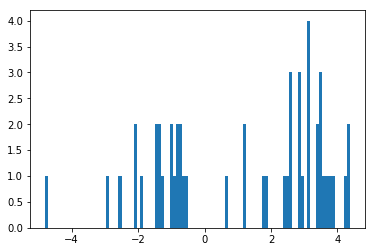

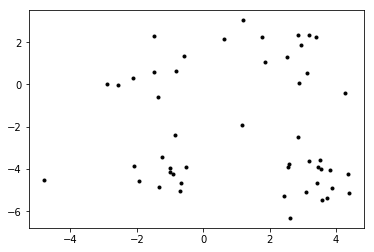

In [3]:
col = 0
plt.figure()
plt.hist(data_set.x[:, col], bins=100);

col1 = 0
col2 = 1
plt.figure()
plt.plot(data_set.x[:, col1], data_set.x[:, col2], 'k.');

In [4]:
# Parameters approximating the true distribution

tau_true = np.zeros_like(tau_init)
tau_true_scale = 15.
tau_true[:, 0] = deepcopy(pi) * tau_true_scale
tau_true[:, 1] = tau_true_scale

nu_true = np.zeros_like(nu_init)
nu_true[Z == 1] = 0.999
nu_true[Z == 0] = 0.001

phi_mu_true = np.zeros_like(phi_mu_init)
phi_mu_true[:] = A.transpose()
phi_var_true = np.zeros_like(phi_var_init)
phi_var_true[:] = 0.01

params_true = packing.pack_params(deepcopy(tau_true), deepcopy(phi_mu_true),
                                  deepcopy(phi_var_true), deepcopy(nu_true))

In [5]:
true_init = False
if true_init:
    tau, phi_mu, phi_var, nu = data_set.unpack_params(params_true)
else:
    tau, phi_mu, phi_var, nu = data_set.unpack_params(params_init)

tau, nu, phi_mu, phi_var = data_set.run_cavi(tau, nu, phi_mu, phi_var, max_iter=100, tol=1e-6)

cavi_tau = deepcopy(tau)
cavi_phi_mu = deepcopy(phi_mu)
cavi_phi_var = deepcopy(phi_var)
cavi_nu = deepcopy(nu)

Step 0 objective: 33.86830252608767
Step 10 objective: 0.16855110958805497
Step 20 objective: 7.798693473404228e-05
Step 30 objective: 9.034479298009046e-07
Done with CAVI.


In [6]:
# CAVI can return nu values that are too close to 0 or 1 for the encoding.
nu_tol = 1e-8
cavi_nu_trim = deepcopy(cavi_nu)
cavi_nu_trim[cavi_nu_trim < nu_tol] = nu_tol
cavi_nu_trim[cavi_nu_trim > 1 - nu_tol] = 1 - nu_tol

cavi_params = packing.pack_params(cavi_tau, cavi_phi_mu, cavi_phi_var, cavi_nu_trim)
print(np.all(np.isfinite(cavi_params)))

True


In [7]:
data_set.trace.reset()
vb_opt = data_set.run_newton_tr(cavi_params, maxiter=50, gtol=1e-2)
tr_params = deepcopy(vb_opt.x)
tr_tau, tr_phi_mu, tr_phi_var, tr_nu = data_set.unpack_params(tr_params)


Step 0 objective: -324.1166430450337
Optimization terminated successfully.
         Current function value: -324.116643
         Iterations: 1
         Function evaluations: 2
         Gradient evaluations: 2
         Hessian evaluations: 0
Done with Newton trust region.


In [8]:
print ('CAVI:')
print (cavi_phi_mu.transpose())

print ('Full TR:')
tau, phi_mu, phi_var, nu = data_set.unpack_params(tr_params)
print (phi_mu.transpose())

print ('Truth:')
print (A)

CAVI:
[[-1.38893495 -4.01490838]
 [ 2.85744278 -2.84252141]
 [ 2.11953515  1.9052959 ]]
Full TR:
[[-1.38893484 -4.01490835]
 [ 2.85744266 -2.84252138]
 [ 2.11953521  1.90529591]]
Truth:
[[-1.51981911  1.36489297]
 [ 0.07076695 -5.93156821]
 [ 4.53218492  0.19643952]]


Cavi residuals: 63.33308362438211    Trust residuals: 63.33308243737516      True residuals: 78.48308573612925


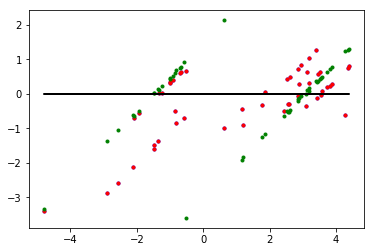

In [9]:
cavi_resid = data_set.x - data_set.get_prediction(cavi_params)
tr_resid = data_set.x - data_set.get_prediction(tr_params)
true_resid = data_set.x - np.matmul(Z, A)

plt.figure()
col = 0
plt.plot(data_set.x[:, col], tr_resid[:, col], '.b')
plt.plot(data_set.x[:, col], cavi_resid[:, col], '.r')
plt.plot(data_set.x[:, col], true_resid[:, col], '.g')
plt.plot(data_set.x[:, col], np.full_like(data_set.x[:, col], 0.), 'k')

print('Cavi residuals: {}    Trust residuals: {}      True residuals: {}'.format(
       np.sum(np.abs(cavi_resid)), np.sum(np.abs(tr_resid)), np.sum(np.abs(true_resid))))


In [10]:
def get_moments(params, data_set):
    # Return moments of interest.
    tau, phi_mu, phi_var, nu = data_set.unpack_params(params)
    e_log_pi, e_log_pi2, e_mu, phi_moment2, nu_moment = \
        vi.get_moments(tau, nu, phi_mu, phi_var)
    return e_log_pi, e_mu

def get_moments_vector(params, data_set):
    e_log_pi, e_mu = get_moments(params, data_set)
    return packing.pack_moments(e_log_pi, e_mu)

get_moments_vector_jac = jacobian(get_moments_vector)

jac_time = time.time()
moment_jac = get_moments_vector_jac(tr_params, data_set)
jac_time = time.time() - jac_time

par_hp_hess_time = time.time()
par_hp_hess = data_set.get_kl_sens_hess(tr_params, hyper_params)
par_hp_hess_time = time.time() - par_hp_hess_time


In [11]:
hess_time = time.time()
kl_hess = data_set.get_kl_hessian(tr_params)
hess_time = time.time() - hess_time
kl_hess_eigvals = np.linalg.eigvals(kl_hess)
print (hess_time)

2.1814417839050293


In [12]:
print (np.max(kl_hess_eigvals))
print (np.min(kl_hess_eigvals))

43.4551278231
8.91145429607e-09


In [13]:
# Eq. 18 from our paper.  The -1 comes from the fact that par_hp_hess is of the
# KL divergence, not the expected log probability.
sensitivity_operator = -1 * np.linalg.solve(kl_hess, par_hp_hess.T)
moment_sensitivity = np.matmul(moment_jac, sensitivity_operator)

print(moment_sensitivity)
np.shape(moment_sensitivity)

[[  6.71010190e-03  -2.62881180e-05   6.42024383e-03]
 [  9.78672001e-03  -1.29021295e-04   1.03925381e-02]
 [  9.08211057e-03   4.37497820e-04  -4.31875850e-02]
 [ -1.45649864e-03  -3.71388759e-03   8.06211609e-02]
 [ -1.63417586e-03   2.88667967e-03   2.38587264e-01]
 [ -2.15908257e-03   1.02771609e-03  -3.11861157e-01]
 [ -3.25486654e-03  -3.79073712e-03   7.89476959e-02]
 [  1.23064484e-04  -3.01776013e-03   3.24817833e-01]
 [  1.18778774e-03   4.11744146e-03  -2.72958085e-01]]


(9, 3)

In [14]:
# The third column is sigma_eps.

sigma_eps_col = 2
e_log_pi_sigma_eps_sens, e_mu_sigma_eps_sens = \
    packing.unpack_moments(moment_sensitivity[:, sigma_eps_col], k_approx, D)
    
print('Sensitivity of e_log_pi to sigma_eps:')
print(e_log_pi_sigma_eps_sens)

print('Sensitivity of e_mu to sigma_eps:')
print(e_mu_sigma_eps_sens)

Sensitivity of e_log_pi to sigma_eps:
[ 0.00642024  0.01039254 -0.04318758]
Sensitivity of e_mu to sigma_eps:
[[ 0.08062116  0.23858726 -0.31186116]
 [ 0.0789477   0.32481783 -0.27295809]]


In [15]:
# Perturb and re-rerun to check the sensitivity.

epsilon = 1e-1
data_set_perturb = ds.DataSet(X, k_approx, alpha, sigma_eps + epsilon, sigma_a)
data_set_perturb.trace.print_every = 1
vb_opt_perturb = data_set_perturb.run_newton_tr(tr_params)

Step 0 objective: -284.9486640100983
Step 1 objective: -284.99187866638977
Step 2 objective: -285.01698744401034
Step 3 objective: -285.02173630611685
Step 4 objective: -285.0332027635734
Step 5 objective: -285.0377879120543
Step 6 objective: -285.03908017001095
Step 7 objective: -285.0406646629115
Step 8 objective: -285.04372129173464
Step 9 objective: -285.0443100372954
Step 10 objective: -285.0441731871413
Step 11 objective: -285.04501368276055
Step 12 objective: -285.04511806885614
Step 13 objective: -285.0455424374637
Step 14 objective: -285.04597538629747
Step 15 objective: -285.04602710448086
Step 16 objective: -285.0459006670206
Step 17 objective: -285.0461061279199
Step 18 objective: -285.0461679940948
Step 19 objective: -285.046215981183
Step 20 objective: -285.0462224628958
Step 21 objective: -285.046192244582
Step 22 objective: -285.0462311390928
Step 23 objective: -285.04623290937167
Step 24 objective: -285.0462372166627
Step 25 objective: -285.0462353952367
Step 26 object

In [16]:
e_log_pi, e_mu = get_moments(tr_params, data_set)
e_log_pi_perturb, e_mu_perturb = get_moments(vb_opt_perturb.x, data_set)

print('Measured sensitivity of e_mu to sigma_eps:')
print((e_mu_perturb - e_mu) / epsilon)

print('Sensitivity of e_mu to sigma_eps:')
print(e_mu_sigma_eps_sens)

print('Measured sensitivity of e_log_pi to sigma_eps:')
print((e_log_pi_perturb - e_log_pi) / epsilon)

print('Sensitivity of e_log_pi to sigma_eps:')
print(e_log_pi_sigma_eps_sens)

Measured sensitivity of e_mu to sigma_eps:
[[ 0.09711847  0.27259517 -0.34997092]
 [ 0.10457339  0.37186709 -0.32746223]]
Sensitivity of e_mu to sigma_eps:
[[ 0.08062116  0.23858726 -0.31186116]
 [ 0.0789477   0.32481783 -0.27295809]]
Measured sensitivity of e_log_pi to sigma_eps:
[ 0.0087524   0.00998368 -0.04750362]
Sensitivity of e_log_pi to sigma_eps:
[ 0.00642024  0.01039254 -0.04318758]


In [17]:
# set up influence function
jac_log_pi_lh = jacobian(data_set.get_log_q_pi, 0)

def g_bar_pi(pi): 
    tmp = np.linalg.solve(kl_hess, jac_log_pi_lh(tr_params, pi))
    return np.dot(moment_jac, tmp)

def Influence_pi(pi, alpha, k_approx): 
    return np.exp(ds.log_q_pi(pi, tr_tau) - ds.log_p0_pi(pi, alpha, k_approx)) * g_bar_pi(pi)

/home/runjing_liu/anaconda3/lib/python3.6/site-packages/autograd/core.py:84: RuntimeWarning: divide by zero encountered in log
  result_value = self.fun(*argvals, **kwargs)
/home/runjing_liu/Documents/BNP/Variational_BNP_robustness/finite_approx/data_set_lib.py:152: RuntimeWarning: invalid value encountered in multiply
  + (tau[:,1] - 1) * np.log(1 - pi))
/home/runjing_liu/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in double_scalars


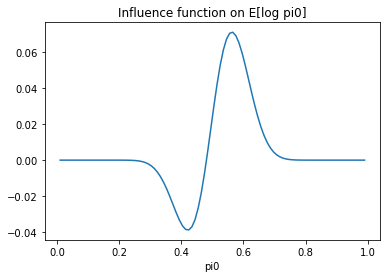

In [18]:
# plot influence function

n_ticks = 100
col_prior = 0 # which pi you're plotting in the prior
col_post = 0 # which pi you're looking at in the posterior

pi1_plt = np.tile(pi, (n_ticks, 1))
pi1_plt[:,col_prior] = np.linspace(0,1,n_ticks)

y = np.zeros(n_ticks)

for i in range(n_ticks): 
    y[i] = Influence_pi(pi1_plt[i,:], alpha, k_approx)[col_post]
    
plt.plot(np.linspace(0,1,n_ticks), y)
plt.xlabel('pi' + str(col))
plt.title('Influence function on E[log pi' + str(col_post) + ']')
